In [1]:
# 필요한 라이브러리 import 하기

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import pandas as pd
import numpy as np

import os
from os.path import join

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
# 데이터 불러오기

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
# 데이터 전처리하기

In [7]:
# 1) 결측치 확인

In [8]:
datas = pd.concat((train.drop(columns='price'), test), axis = 0)  # train, test data 모두 확인
datas.isna().sum().sum()  # 결측치 확인

0

In [9]:
# 2) date feature: 정수형 데이터로 처리

In [10]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
# 3) y 변수에 price를 넣어두고, train에서는 삭제하기

In [12]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [13]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [14]:
# 4) id 컬럼 삭제하기

In [15]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [16]:
# rain 데이터와 동일하게 test 데이터도 전처리하기

In [17]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [18]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [19]:
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [20]:
# target (y) 확인하기

In [21]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [22]:
# 변수 간 상관관계 확인

In [24]:
import scipy as sp

ds = pd.read_csv(train_data_path)

cor_abs = abs(ds.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=20, columns = 'price').index
cor = np.array(sp.stats.spearmanr(ds[cor_cols].values))[0]
cor_cols

Index(['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above',
       'bathrooms', 'lat', 'bedrooms', 'floors', 'view', 'sqft_basement',
       'waterfront', 'yr_renovated', 'yr_built', 'sqft_lot', 'long',
       'sqft_lot15', 'id', 'condition', 'zipcode'],
      dtype='object')

<AxesSubplot:>

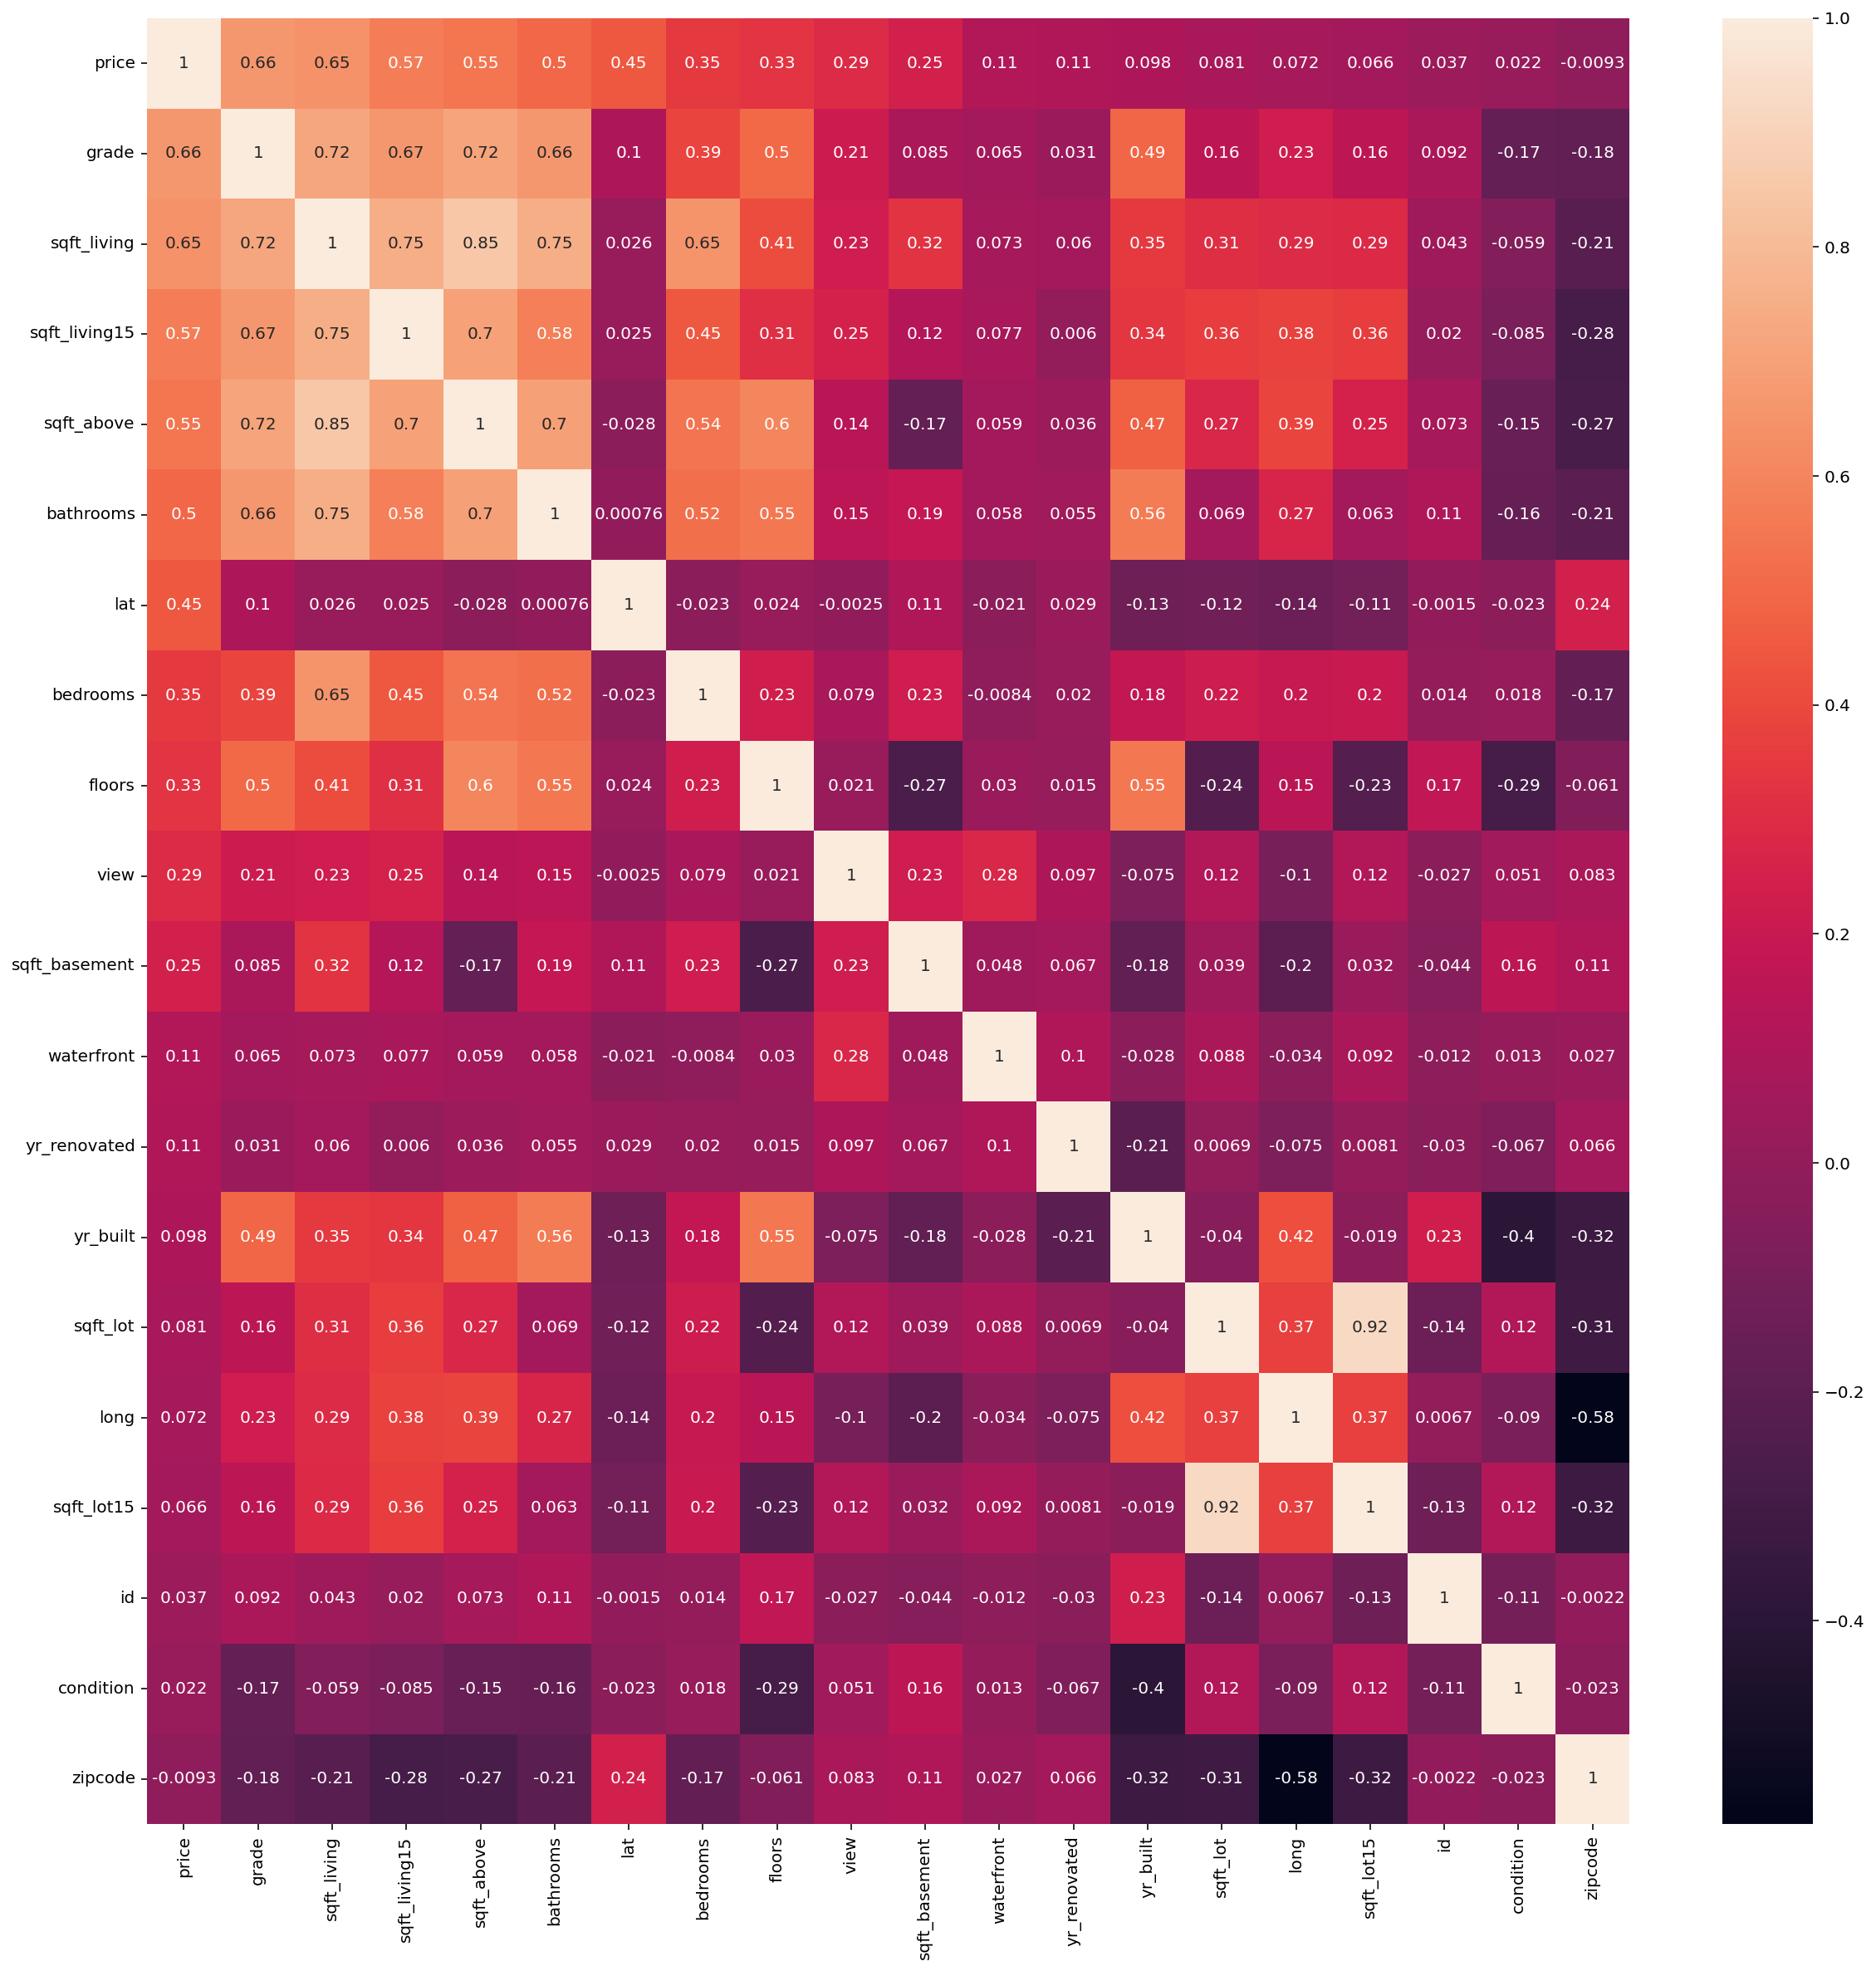

In [25]:
plt.figure(figsize=(20, 20))
sns.heatmap(cor, annot=True, xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [26]:
# `y`의 분포 확인하기

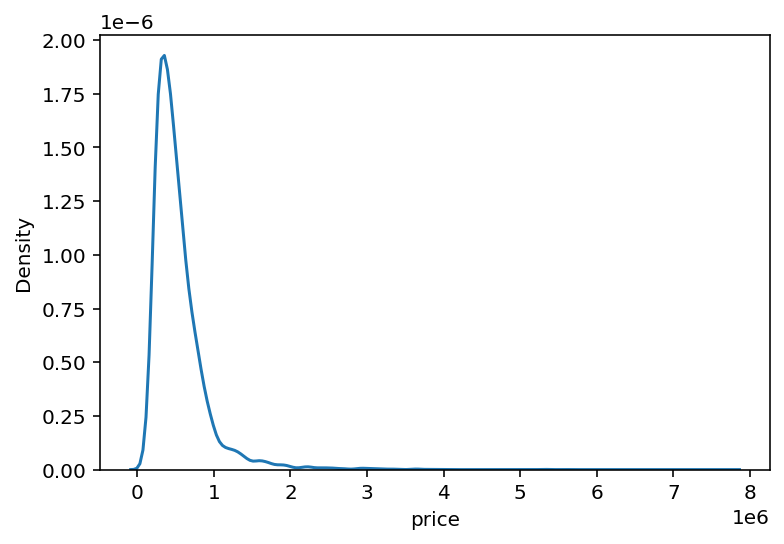

In [27]:
sns.kdeplot(y)
plt.show()

In [28]:
# np.log1p() 함수 통해 로그 변환해주기

In [29]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

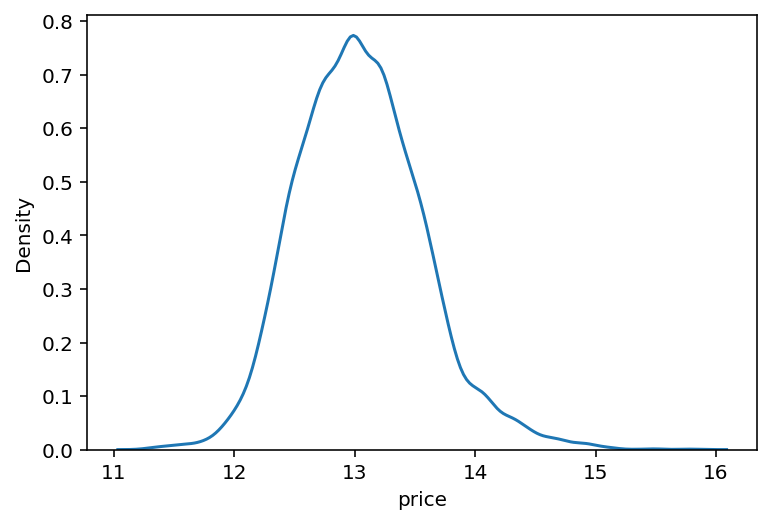

In [30]:
sns.kdeplot(y)
plt.show()

In [31]:
# 전체 데이터의 자료형 확인하기

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [33]:
# 모델 튜닝

In [34]:
# 필요 라이브러리 가져오기

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [36]:
# RMSE 점수 계산 함수 정의

In [37]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [38]:
# 아래 네 가지 모델 가져오기
# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor

In [39]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [40]:
# 모델 인스턴스를 생성한 후 models 리스트에 넣어주기

In [42]:
random_state=2020        # 고정값으로 세팅

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [43]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [44]:
# 데이터셋 분리부터 모델 학습, 예측, RMSE 계산, 결과값 저장까지의 과정들을 함수로 만들기

In [45]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

get_scores(models, train, y)

In [46]:
# 하이퍼 파라미터 튜닝 - 그리드 탐색 사용

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터 준비

In [49]:
param_grid = {
    'n_estimators' : [100, 500],
    'max_depth' : [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

In [50]:
# 그리드 탐색을 수행하고 그 결과를 확인하는 과정을 함수로 만들기

In [51]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    # params, score에 각 조합에 대한 결과를 저장합니다. 
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    # RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [52]:
# my_GridSearch() 함수로 간단한 그리드 탐색 실행

In [53]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=100; total time=   2.4s
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=500; total time=   7.8s
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_leaf=8, min_samples_split=16, n_estimators

,learning_rate,max_depth,min_samples_leaf,min_samples_split,n_estimators,score,RMSLE
137,0.05,12,12,20,500,-0.025869,0.160839
135,0.05,12,12,16,500,-0.025869,0.160839
133,0.05,12,12,8,500,-0.025869,0.160839
117,0.05,10,12,16,500,-0.025882,0.160878
119,0.05,10,12,20,500,-0.025882,0.160878
...,...,...,...,...,...,...,...
10,0.01,6,12,20,100,-0.081542,0.285555
8,0.01,6,12,16,100,-0.081542,0.285555
2,0.01,6,8,16,100,-0.081593,0.285644
4,0.01,6,8,20,100,-0.081593,0.285644


In [ ]:
# 가장 좋은 조합은 max_depth=10, n_estimators=100, 
# min_samples_leaf=18, min_samples_split=8이므로
# 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과 생성하기

In [54]:
model = LGBMRegressor(max_depth=12, n_estimators=500, learning_rate=0.05, min_samples_leaf=12, min_samples_split=20, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.10376702, 13.08569138, 14.1403128 , ..., 13.07466744,
       12.71753936, 12.98503062])

In [55]:
# 예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌리기

In [56]:
prediction = np.expm1(prediction)  
prediction

array([ 490786.74541005,  481995.13534448, 1383755.96362982, ...,
        476710.82099475,  333546.09958797,  435839.05825531])

In [57]:
# sample_submission.csv 파일을 가져오기

In [58]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [59]:
# 위 데이터프레임에 생성한 모델의 예측 값 덮어씌우기

In [60]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.907867e+05
1,15036,4.819951e+05
2,15037,1.383756e+06
3,15038,3.054117e+05
4,15039,3.313041e+05


In [61]:
# 위 데이터를 csv 파일로 저장하기 (파일이름에 모델의 종류와 RMSLE 값 넣어주기)

In [63]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399_last')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399_last.csv
